DownSampling_180

DropOut False

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt

df = pd.read_csv('../Preprocessing/data_downsampling_180.csv', header=None)
df_y = pd.read_csv('../Preprocessing/data_output.csv', header=None)

X = df.values
y = df_y.iloc[:, 0].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

y_onehot = to_categorical(y_encoded, num_classes=5)

X_train, X_val, y_train, y_val = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_val = X_val.reshape(-1, X_val.shape[1], 1)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# LSTM 모델
model = Sequential()

# LSTM-1
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# LSTM-2
model.add(LSTM(units=100))
model.add(Dropout(0.2))

model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=5, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 180, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 180, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 3

In [3]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)


Epoch 1/20
2738/2738 [==============================] - 245s 88ms/step - loss: 0.4471 - accuracy: 0.8772 - val_loss: 0.2772 - val_accuracy: 0.9258
Epoch 2/20
2738/2738 [==============================] - 241s 88ms/step - loss: 0.2275 - accuracy: 0.9386 - val_loss: 0.1701 - val_accuracy: 0.9542
Epoch 3/20
2738/2738 [==============================] - 241s 88ms/step - loss: 0.1641 - accuracy: 0.9555 - val_loss: 0.1316 - val_accuracy: 0.9646
Epoch 4/20
2738/2738 [==============================] - 240s 88ms/step - loss: 0.1389 - accuracy: 0.9625 - val_loss: 0.1079 - val_accuracy: 0.9696
Epoch 5/20
2738/2738 [==============================] - 241s 88ms/step - loss: 0.1235 - accuracy: 0.9666 - val_loss: 0.1087 - val_accuracy: 0.9712
Epoch 6/20
2738/2738 [==============================] - 241s 88ms/step - loss: 0.1088 - accuracy: 0.9714 - val_loss: 0.0886 - val_accuracy: 0.9753
Epoch 7/20
2738/2738 [==============================] - 240s 88ms/step - loss: 0.0935 - accuracy: 0.9746 - val_loss: 0

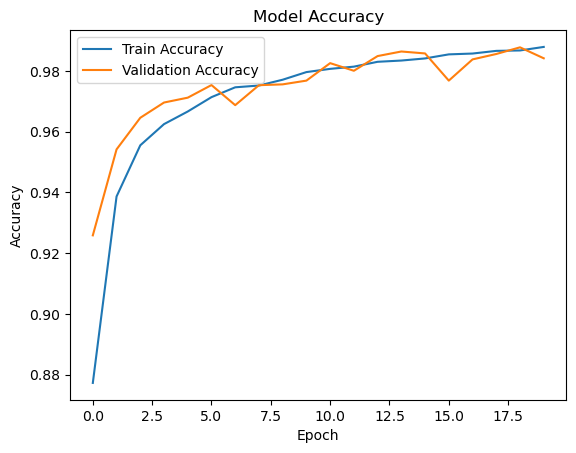

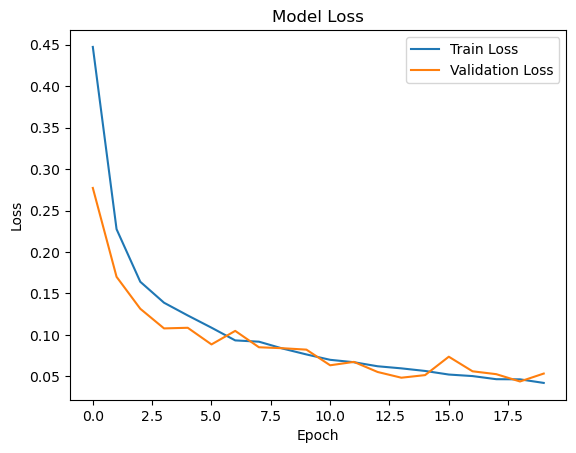

In [4]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# 검증 데이터셋에 대한 예측 수행
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)  

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

685/685 [==============================] - 18s 26ms/step


TP (True Positive): 해당 클래스로 올바르게 예측된 샘플 수

TN (True Negative): 해당 클래스와 관련이 없는 샘플이 올바르게 예측된 수

FP (False Positive): 해당 클래스가 아닌 샘플을 해당 클래스로 잘못 예측한 수

FN (False Negative): 해당 클래스를 다른 클래스로 잘못 예측한 수

Accuracy: 각 클래스별로 올바르게 예측된 샘플의 비율

전체 클래스의 영향을 반영한 정확도
(TP + TN) / (TP + TN + FP + FN)

In [6]:
def calculate_tptnfpfn(conf_matrix, class_index):
    TP = conf_matrix[class_index, class_index]
    FN = conf_matrix[class_index, :].sum() - TP
    FP = conf_matrix[:, class_index].sum() - TP
    TN = conf_matrix.sum() - (TP + FN + FP)
    return TP, TN, FP, FN

metrics = []

for i in range(len(conf_matrix)):
    TP, TN, FP, FN = calculate_tptnfpfn(conf_matrix, i)
    metrics.append({
        'Class': label_encoder.classes_[i],
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'Accuracy': (TP + TN) / (TP + TN + FP + FN)
    })

metrics_df = pd.DataFrame(metrics)

print(metrics_df)


  Class     TP     TN   FP   FN  Accuracy
0     F    106  21656  101   36  0.993744
1     N  17979   3615  137  168  0.986072
2     Q   1600  20264   23   12  0.998402
3     S    459  21326   39   75  0.994794
4     V   1408  20388   47   56  0.995297


각 개별 클래스의 정확도 TP/ (TP + FN)

In [7]:
# 각 클래스별 정확도 계산
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

import pandas as pd

class_labels = label_encoder.classes_ 
accuracy_df = pd.DataFrame({
    'Class': class_labels,
    'Accuracy': class_accuracy
})

print(accuracy_df)


  Class  Accuracy
0     F  0.746479
1     N  0.990742
2     Q  0.992556
3     S  0.859551
4     V  0.961749


In [8]:
from sklearn.metrics import accuracy_score

# 전체 정확도 계산
overall_accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'Overall Accuracy: {overall_accuracy:.4f}')


Overall Accuracy: 0.9842
